# 1. Primeiros passos

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2
from pprint import pprint
from tqdm import tqdm
from typing import Optional, List, Tuple

In [3]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

In [6]:
from transformers import SamModel, SamProcessor

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Model: Tesla T4


In [8]:
kaggle = True

if kaggle == True:
    base = os.path.join('/kaggle', 'input', 'cod10k-v3', 'COD10K-v3')
else:
    base = "COD10K-v3"

train_json_path   = os.path.join(base, "Train", "CAM_Instance_Train.json")
train_images_path = os.path.join(base, "Train", "Image")
train_masks_path  = os.path.join(base, "Train", "GT_Instance")

test_json_path   = os.path.join(base, "Test", "CAM_Instance_Test.json")
test_images_path = os.path.join(base, "Test", "Image")
test_masks_path  = os.path.join(base, "Test", "GT_Instance")

if not os.path.exists(train_json_path):
    raise FileNotFoundError(f"Arquivo não encontrado: {train_json_path}")
else:
    print("OK")

OK


In [9]:
# Carrega o JSON
with open(train_json_path, "r", encoding="utf-8") as f:
   data_train = json.load(f)
   train_annotations = data_train['annotations']
   train_images = data_train['images']

print(f"Número de imagens de treino: {len(train_images)}")
print("Chaves das imagens:", list(train_images[0].keys()))
print(f"Número de anotações de treino: {len(train_annotations)}")
print("Chaves das anotações:", list(train_annotations[0].keys()))
        
print("\nExemplo de entrada em 'images':")
pprint(train_images[0])
print("\nExemplo de entrada em 'annotations':")
pprint(train_annotations[0])

Número de imagens de treino: 3040
Chaves das imagens: ['id', 'file_name', 'width', 'height', 'date_captured', 'license', 'url']
Número de anotações de treino: 3534
Chaves das anotações: ['id', 'image_id', 'category_id', 'iscrowd', 'area', 'bbox', 'segmentation']

Exemplo de entrada em 'images':
{'date_captured': '2020-08-21 01:23:18.643991',
 'file_name': 'COD10K-CAM-1-Aquatic-1-BatFish-8.jpg',
 'height': 640,
 'id': 1,
 'license': 1,
 'url': '',
 'width': 427}

Exemplo de entrada em 'annotations':
{'area': 68427,
 'bbox': [70.0, 40.0, 315.0, 559.0],
 'category_id': 1,
 'id': 1,
 'image_id': 1,
 'iscrowd': 0,
 'segmentation': [[206.0,
                   598.9980392156863,
                   203.0,
                   598.9980392156863,
                   200.00196078431372,
                   593.0,
                   199.00196078431372,
                   580.0,
                   212.00196078431372,
                   523.0,
                   216.00196078431372,
                   51

In [10]:
# sanity check nos ids de treino
# o dataset tem todos os ids de 1 ate 3040

aux = sorted([x['id'] for x in train_images])

if aux[0] == 1 and aux[-1] == len(aux):
    print("IDs de imagens de treino OK")
else:
    raise ValueError("IDs de imagens de treino com problema")

aux = sorted(list(set([x['image_id'] for x in train_annotations])))

if aux[0] == 1 and aux[-1] == len(aux):
    print("IDs de anotações de treino OK")
else:
    raise ValueError("IDs de anotações de treino com problema")

IDs de imagens de treino OK
IDs de anotações de treino OK


In [11]:
def refactor_train_images(images):
    new_images = [None for _ in range(len(train_images))]
    for img in images:
        new_images[int(img['id']) - 1] = img
    return new_images

def refactor_annotations(annotations):
    new_annotations = [[] for _ in range(len(train_images))]
    for ann in annotations:
        new_annotations[int(ann['image_id']) - 1].append(ann)
    return new_annotations

train_images = refactor_train_images(train_images)
print('tamanha de train_images:', len(train_images))

train_annotations = refactor_annotations(train_annotations)
print('tamanha de annotations:', len(train_annotations))

tamanha de train_images: 3040
tamanha de annotations: 3040


In [12]:
print('Verificando imagens')

for img in train_images:
    fname = img['file_name']
    
    img_path = os.path.join(train_images_path, fname)
    mask_path = os.path.join(train_masks_path, os.path.splitext(fname)[0] + '.png')

    if not os.path.exists(img_path):
        print(f"Arquivo de imagem não encontrado: {img_path}")

    if not os.path.exists(mask_path):
        print(f"Arquivo de máscara não encontrado: {mask_path}")
        
print("Verificação concluída.")

Verificando imagens
Verificação concluída.


# Visualizando o dados

In [13]:
def display_image_and_mask(img_path: str, mask_path: str, bboxes: Optional[list] = None):
    """
    Display an image and its corresponding mask side by side.
    Optionally, draw bounding boxes on the image.
    """
    fname = os.path.basename(img_path)

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    img =  cv2.imread(img_path, cv2.IMREAD_COLOR)  # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    if bboxes:
        for bbox in bboxes:
            x, y, w, h = map(int, bbox)
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 5)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title(f"Image: {fname}")
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

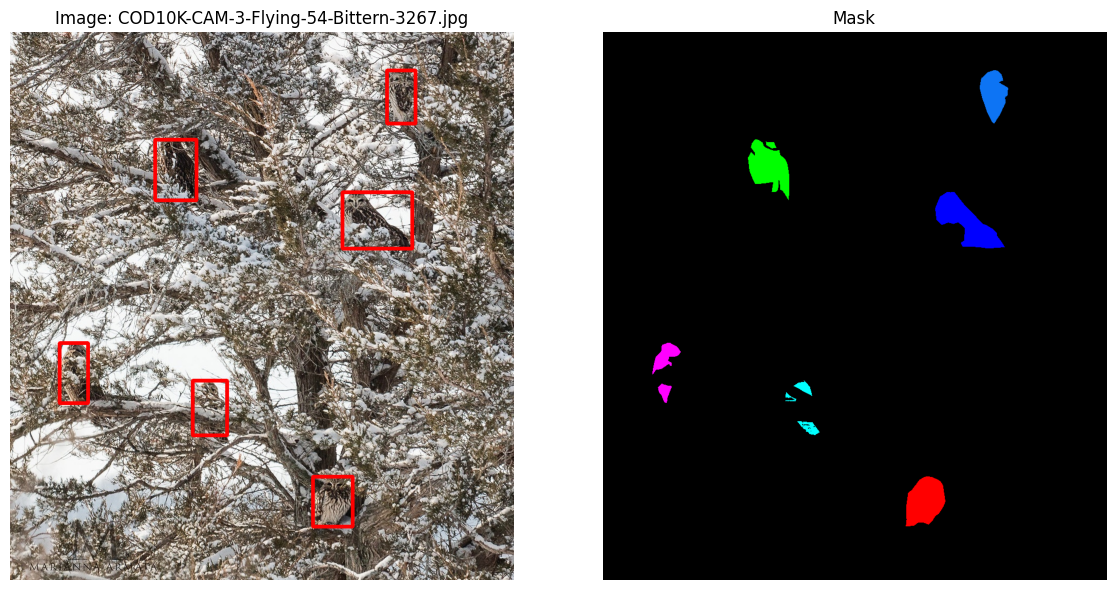

In [14]:
# pick a random filename from the list
random_idx = 1963 #np.random.randint(0, len(train_images)) # 2 passaros id = 1834
fname = train_images[random_idx]['file_name']

img_path = os.path.join(train_images_path, fname)
mask_path = os.path.join(train_masks_path, os.path.splitext(fname)[0] + '.png')
bboxes = [ann['bbox'] for ann in train_annotations[random_idx]]

display_image_and_mask(img_path, mask_path, bboxes)

In [15]:
# print("Unique colors in mask (BGR):", np.unique(mask.reshape(-1, mask.shape[2]), axis=0))

In [16]:
len(train_images), len(train_annotations)

(3040, 3040)

In [17]:
# heuristica para encontrar a cor da mascara de cada bbox
for v_ann in tqdm(train_annotations):
    image_id = v_ann[0]['image_id']
    image_name = train_images[image_id - 1]['file_name']
    
    if len(v_ann) == 1: # apenas 1 objeto na imagem
        v_ann[0]['color'] = [0, 0, 255] # vermelho eh cor padrao
        continue
    
    mask_path = os.path.join(train_masks_path, os.path.splitext(image_name)[0] + '.png')
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) # 3 canais
    
    bboxes = [ann['bbox'] for ann in v_ann]
    bboxes = [[int(x[0]), int(x[1]), int(x[2])+int(x[0]), int(x[3])+int(x[1])] for x in bboxes]
    
    candidates = []
    for idx, bbox in enumerate(bboxes):
        mask_crop = mask[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        crop_unique_colors, crop_count = np.unique(mask_crop.reshape(-1, mask_crop.shape[2]), axis=0, return_counts=True)
        crop_unique_colors = crop_unique_colors.tolist()
        crop_count = crop_count.tolist()
        
        for color, count in zip(crop_unique_colors, crop_count):
            if color != [0,0,0]:
                candidates.append((count, idx, color))

    color_by_box = [False for _ in range(len(bboxes))]
    for count, idx, color in candidates:
        if color_by_box[idx] == False:
            color_by_box[idx] = True
            v_ann[idx]['color'] = color

pprint(train_annotations[0])

100%|██████████| 3040/3040 [01:20<00:00, 37.54it/s] 

[{'area': 68427,
  'bbox': [70.0, 40.0, 315.0, 559.0],
  'category_id': 1,
  'color': [0, 0, 255],
  'id': 1,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [[206.0,
                    598.9980392156863,
                    203.0,
                    598.9980392156863,
                    200.00196078431372,
                    593.0,
                    199.00196078431372,
                    580.0,
                    212.00196078431372,
                    523.0,
                    216.00196078431372,
                    517.0,
                    216.00196078431372,
                    508.0,
                    212.00196078431372,
                    496.0,
                    201.00196078431372,
                    487.0,
                    197.00196078431372,
                    472.0,
                    200.00196078431372,
                    457.0,
                    191.0,
                    444.9980392156863,
                    185.00196078431372,
                

# Testando o modelo base

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Analisando: COD10K-CAM-3-Flying-65-Owl-4559.jpg


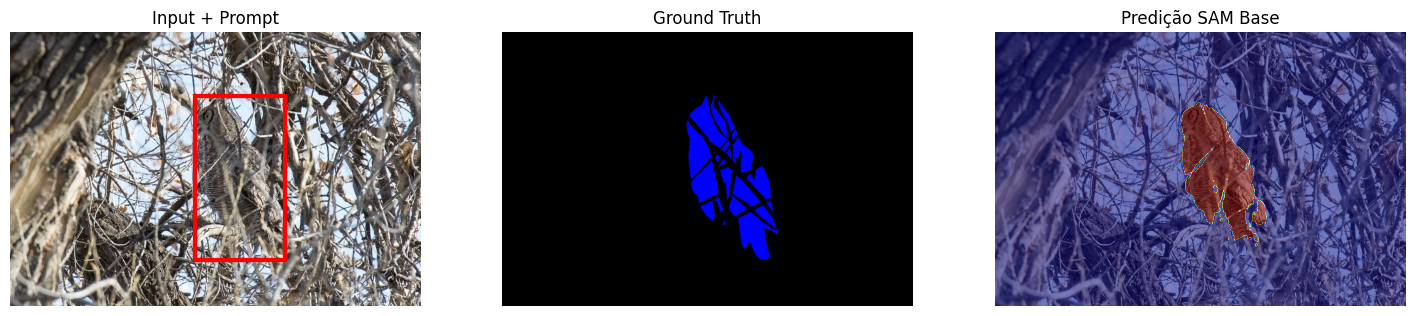

Analisando: COD10K-CAM-2-Terrestrial-49-Worm-2946.jpg


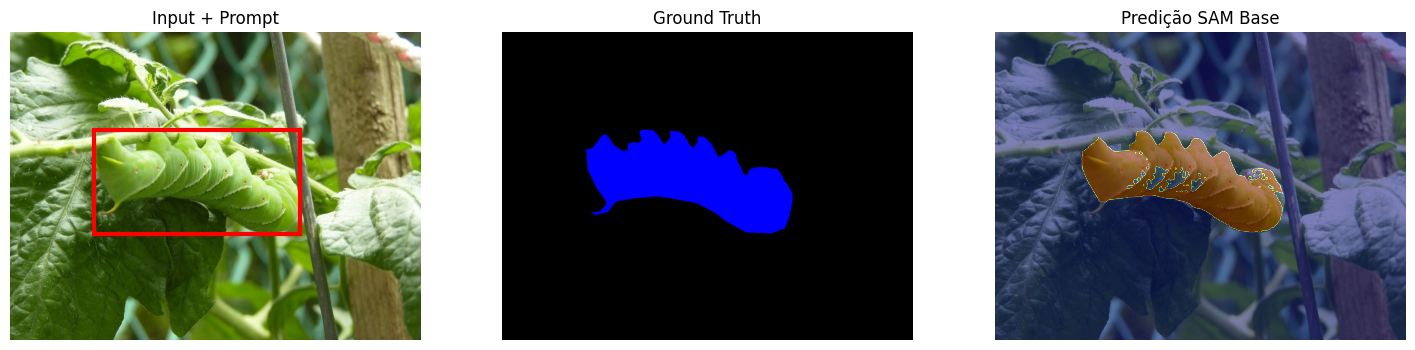

Analisando: COD10K-CAM-2-Terrestrial-21-Ant-1245.jpg


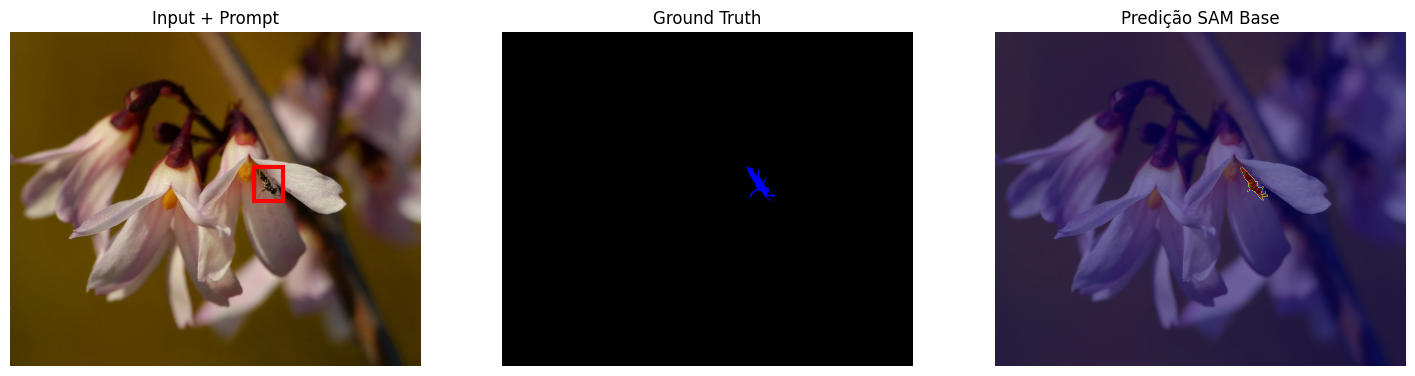

In [20]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

def small_test_base_model(idx):
    # Recuperar informações
    img_info = train_images[idx]
    ann_info = train_annotations[idx]
    
    if not ann_info:
        print(f"Imagem {idx} sem bbox. Pulando.")
        return

    # 1. Carregar Imagem
    img_path = os.path.join(train_images_path, img_info['file_name'])
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # 2. Carregar Ground Truth para comparação
    mask_fname = os.path.splitext(img_info['file_name'])[0] + '.png'
    mask_path = os.path.join(train_masks_path, mask_fname)
    gt_mask = cv2.imread(mask_path)
    
    # 3. Preparar Prompt
    x, y, w, h = map(int, ann_info[0]['bbox'])
    input_box = [x, y, x + w, y + h]

    print(f"Analisando: {img_info['file_name']}")

    # 4. Pré-processamento
    inputs = processor(
        original_image, 
        input_boxes=[[input_box]], 
        return_tensors="pt"
    ).to(device)
    
    # Inferência
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks, 
        inputs["original_sizes"], 
        inputs["reshaped_input_sizes"]
    )
    
    # Shape da saída: [Batch, Num_Prompts, H, W]
    mask_pred = masks[0].squeeze().cpu().numpy()
    mask_pred = (mask_pred > 0).astype(np.uint8)

    # --- PLOTAGEM ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Coluna 1: Input + Box
    axes[0].imshow(original_image)
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=3)
    axes[0].add_patch(rect)
    axes[0].set_title("Input + Prompt")
    
    # Coluna 2: Ground Truth
    axes[1].imshow(original_image)
    green_mask = np.zeros_like(original_image)
    green_mask[:, :, 1] = 255 
    axes[1].imshow(gt_mask)
    axes[1].set_title("Ground Truth")

    # Coluna 3: Predição SAM
    axes[2].imshow(original_image)
    axes[2].imshow(mask_pred, cmap='jet', alpha=0.5) 
    axes[2].set_title("Predição SAM Base")

    for ax in axes: ax.axis('off')
    plt.show()

# Testar novamente
for _ in range(3):
    idx = np.random.randint(0, len(train_images))
    small_test_base_model(idx)

# 2. Preparando dataset

In [26]:
class SAMDataset(Dataset):
    def __init__(self, data_list, image_root, mask_root, processor):
        self.data_list = data_list
        self.image_root = image_root
        self.mask_root = mask_root
        self.processor = processor

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_info, annotations = self.data_list[idx]

        # 1. Carregar Imagem
        img_path = os.path.join(self.image_root, image_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 2. Carregar a Máscara de Instância
        mask_fname = os.path.splitext(image_info['file_name'])[0] + '.png'
        mask_path = os.path.join(self.mask_root, mask_fname)
        
        instance_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) # 3 canais

        input_boxes = []
        ground_truth_masks = []

        for ann in annotations:
            x, y, w, h = map(int, ann['bbox'])
            input_boxes.append([x, y, x + w, y + h])
                        
            ann_color = ann['color'] # 3 canais

            # 3. Criar máscara binária para a instância atual
            binary_mask = np.all(instance_mask == ann_color, axis=-1).astype(np.uint8)

            # 4. Resize para 256x256 (padrão SAM)
            resized_mask = cv2.resize(binary_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            ground_truth_masks.append(resized_mask)

        # Processar pelo SamProcessor
        inputs = self.processor(
            image,
            input_boxes=[input_boxes], 
            return_tensors="pt"
        )
        
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        
        # Converter para tensor
        inputs["ground_truth_masks"] = torch.tensor(np.array(ground_truth_masks)).long()

        return inputs

In [27]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    ground_truth_masks = [item["ground_truth_masks"] for item in batch] # Lista de tensores
    input_boxes = [item["input_boxes"] for item in batch] # Lista de listas
    
    return {
        "pixel_values": pixel_values,
        "ground_truth_masks": ground_truth_masks,
        "input_boxes": input_boxes
    }

In [28]:
def plot_dataset_item(item):
    """
    Plots the image and ground truth masks from a dataset item.
    """
    pixel_values = item['pixel_values'].permute(1, 2, 0).numpy().astype(np.uint8)
    pixel_values = pixel_values.clip(0, 255)
    ground_truth_masks = item['ground_truth_masks'].numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(ground_truth_masks) + 1, 1)
    plt.imshow(pixel_values)
    plt.title("Image")
    plt.axis("off")

    for i, mask in enumerate(ground_truth_masks):
        plt.subplot(1, len(ground_truth_masks) + 1, i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Train: 2432 | Val: 304 | Test: 304
pixel_values: shape=torch.Size([3, 1024, 1024]), dtype=torch.float32
original_sizes: shape=torch.Size([2]), dtype=torch.int64
reshaped_input_sizes: shape=torch.Size([2]), dtype=torch.int64
input_boxes: shape=torch.Size([1, 4]), dtype=torch.float64
ground_truth_masks: shape=torch.Size([1, 256, 256]), dtype=torch.int64


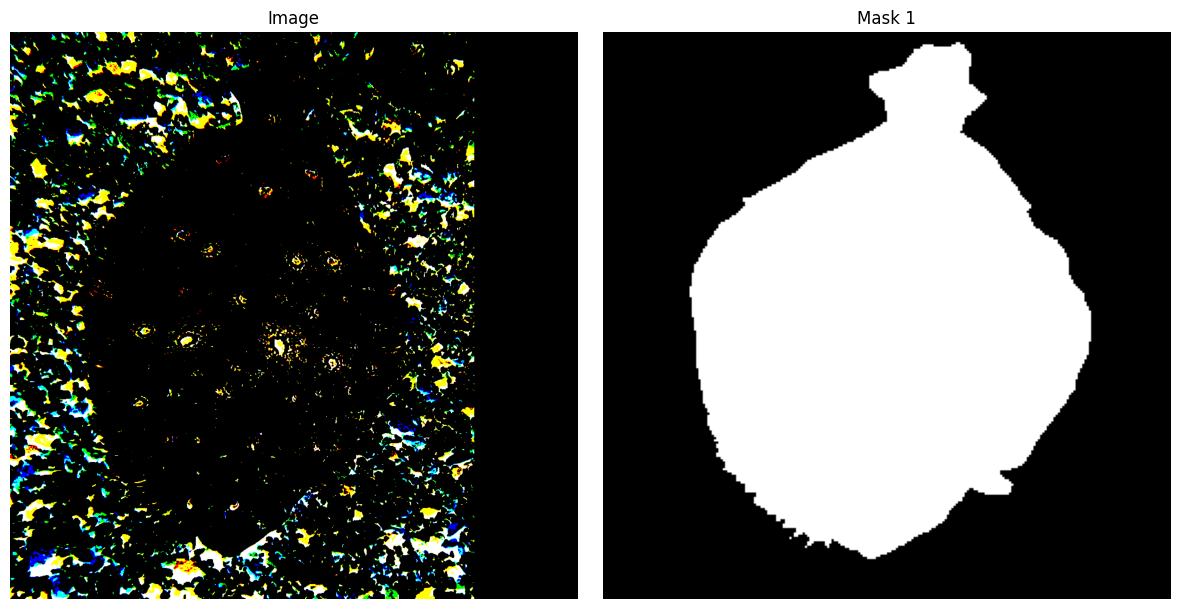

In [24]:
# TESTE DO DATASET

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

all_data = [(img, ann) for img, ann in zip(train_images, train_annotations)]

np.random.seed(22)
indices = np.random.permutation(len(all_data))

train_frac = 0.8
val_frac   = 0.1

n_total = len(indices)
n_train = int(train_frac * n_total)
n_val   = int(val_frac * n_total)
n_test  = n_total - n_train - n_val

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

def subset(data, idxs):
    return [data[i] for i in idxs]

train_dataset = SAMDataset(
    data_list=subset(all_data, train_idx),
    image_root=train_images_path,
    mask_root=train_masks_path,
    processor=processor
)

val_dataset = SAMDataset(
    data_list=subset(all_data, val_idx),
    image_root=train_images_path,
    mask_root=train_masks_path,
    processor=processor
)

test_dataset = SAMDataset(
    data_list=subset(all_data, test_idx),
    image_root=train_images_path,
    mask_root=train_masks_path,
    processor=processor
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Example of fetching one item
example_item = train_dataset[1963]
for key, value in example_item.items():
    print(f"{key}: shape={value.shape}, dtype={value.dtype}")

plot_dataset_item(example_item)

# Treino

In [29]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Pred é logits, então aplicamos sigmoid
        pred = torch.sigmoid(pred)
        
        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

# Instanciando as perdas
seg_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

def criterion(preds, targets):
    return 0.5 * seg_loss(preds, targets) + 0.5 * bce_loss(preds, targets.float())

In [30]:
# 1. Carregar o Modelo Base
model = SamModel.from_pretrained("facebook/sam-vit-base")

# 2. Congelar Camadas (Freezing)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad = False
    else:
        # Mantemos o mask_decoder treinável
        param.requires_grad = True
    
# Verificar quantos parâmetros serão treinados
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total de Parâmetros: {total_params:,}")
print(f"Parâmetros Treináveis (Mask Decoder): {trainable_params:,}")
print(f"Percentual Treinável: {100 * trainable_params / total_params:.2f}%")

Total de Parâmetros: 93,735,472
Parâmetros Treináveis (Mask Decoder): 4,058,340
Percentual Treinável: 4.33%


In [31]:
if kaggle:
    batch_size = 16
    num_workers = 4
else:
    batch_size = 4
    num_workers = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    collate_fn=collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    collate_fn=collate_fn,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    collate_fn=collate_fn,
)

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

start_epoch = 1
num_epochs = 15
lr = 1e-4
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
train_losses = []
val_losses   = [] 
best_loss = float('inf')

# Carregar pesos de um checkpoint
# "/kaggle/input/sadas/pytorch/default/1/"
checkpoint_to_load =  "/kaggle/working/" + "sam_cod10k_last.pth" # ou None

if checkpoint_to_load and os.path.exists(checkpoint_to_load):
    try:
        checkpoint = torch.load(checkpoint_to_load)
        
        model.load_state_dict(checkpoint['model_state'])
        train_losses = checkpoint['train_losses']
        val_losses   = checkpoint.get("val_losses", [])
        start_epoch = checkpoint['epoch'] + 1

        if len(val_losses) > 0:
            best_loss = min(val_losses)
        
        print(f"Pesos carregados com sucesso de: {checkpoint_to_load}")
    except Exception as e:
        print(f"Erro ao carregar o checkpoint: {e}")
else:
    print("Nenhum checkpoint especificado ou encontrado. Treinando do zero.")

Nenhum checkpoint especificado ou encontrado. Treinando do zero.


In [33]:
print(start_epoch, train_losses)

1 []


In [28]:
scaler = torch.amp.GradScaler('cuda')

for epoch in range(start_epoch, start_epoch + num_epochs):
    # ------------ TREINO ------------
    model.train()
    batch_loss = 0.0
    n_train_steps = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch} [train]")

    for batch in progress_bar:
        pixel_values = batch["pixel_values"].to(device)
        optimizer.zero_grad()
        
        total_current_loss = 0.0

        # Loop por imagem dentro do batch
        for i in range(pixel_values.shape[0]):
            curr_pixel_values = pixel_values[i].unsqueeze(0)  # [1, 3, 1024, 1024]
        
            curr_boxes = batch["input_boxes"][i].to(device)   # [num_boxes, 4]
            curr_boxes = curr_boxes.unsqueeze(0)              # [1, num_boxes, 4]
        
            curr_gt_masks = batch["ground_truth_masks"][i].to(device).unsqueeze(1)  # [N_inst, 1, 256, 256]
        
            with torch.amp.autocast('cuda'):
                outputs = model(
                    pixel_values=curr_pixel_values,
                    input_boxes=curr_boxes,        # <- AGORA É TENSOR 3D
                    multimask_output=False,
                )
                pred_masks = outputs.pred_masks.squeeze(0)     # [N_inst, 1, 256, 256]
        
                loss = criterion(pred_masks, curr_gt_masks)
                total_current_loss += loss

        total_current_loss = total_current_loss / pixel_values.shape[0]

        scaler.scale(total_current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_loss += total_current_loss.item()
        n_train_steps += 1

        avg_batch_loss = batch_loss / n_train_steps
        progress_bar.set_postfix({"train_loss": f"{avg_batch_loss:.4f}"})

    avg_epoch_train_loss = batch_loss / max(1, n_train_steps)
    train_losses.append(avg_epoch_train_loss)

    # ------------ VALIDAÇÃO ------------
    model.eval()
    val_loss_total = 0.0
    n_val_steps = 0

    with torch.no_grad():
        val_bar = tqdm(val_dataloader, desc=f"Epoch {epoch} [val]")
        for batch in val_bar:
            pixel_values = batch["pixel_values"].to(device)

            batch_val_loss = 0.0
            for i in range(pixel_values.shape[0]):
                curr_pixel_values = pixel_values[i].unsqueeze(0)
            
                curr_boxes = batch["input_boxes"][i].to(device)
                curr_boxes = curr_boxes.unsqueeze(0)  # [1, num_boxes, 4]
            
                curr_gt_masks = batch["ground_truth_masks"][i].to(device).unsqueeze(1)
            
                with torch.amp.autocast('cuda'):
                    outputs = model(
                        pixel_values=curr_pixel_values,
                        input_boxes=curr_boxes,
                        multimask_output=False,
                    )
                    pred_masks = outputs.pred_masks.squeeze(0)
                    loss = criterion(pred_masks, curr_gt_masks)
                    batch_val_loss += loss

            batch_val_loss = batch_val_loss / pixel_values.shape[0]
            val_loss_total += batch_val_loss.item()
            n_val_steps += 1

            avg_val_loss = val_loss_total / n_val_steps
            val_bar.set_postfix({"val_loss": avg_val_loss})

    avg_epoch_val_loss = val_loss_total / max(1, n_val_steps)
    val_losses.append(avg_epoch_val_loss)

    print(f"Epoch {epoch} | train_loss = {avg_epoch_train_loss:.4f} | val_loss = {avg_epoch_val_loss:.4f}")

    # ------------ CHECKPOINTS ------------
    # Salva sempre o "last"
    torch.save({
        'model_state': model.state_dict(), 
        'epoch': epoch, 
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, "sam_cod10k_last.pth")

    # Salva "best" com base na validação
    if avg_epoch_val_loss < best_loss:
        best_loss = avg_epoch_val_loss
        torch.save({
            'model_state': model.state_dict(), 
            'epoch': epoch, 
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, "sam_cod10k_best.pth")
        print(">> Novo melhor modelo salvo (val_loss melhorou)")

Epoch 1 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.08s/it, val_loss=0.354]


Epoch 1 | train_loss = 0.3898 | val_loss = 0.3538
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 2 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.324]


Epoch 2 | train_loss = 0.3227 | val_loss = 0.3242
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 3 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.06s/it, val_loss=0.313]


Epoch 3 | train_loss = 0.2909 | val_loss = 0.3135
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 4 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.06s/it, val_loss=0.3]  


Epoch 4 | train_loss = 0.2781 | val_loss = 0.3000
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 5 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.296]


Epoch 5 | train_loss = 0.2636 | val_loss = 0.2962
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 6 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.06s/it, val_loss=0.291]


Epoch 6 | train_loss = 0.2547 | val_loss = 0.2910
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 7 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.09s/it, val_loss=0.292]


Epoch 7 | train_loss = 0.2448 | val_loss = 0.2916


Epoch 8 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.287]


Epoch 8 | train_loss = 0.2388 | val_loss = 0.2871
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 9 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.08s/it, val_loss=0.287]


Epoch 9 | train_loss = 0.2312 | val_loss = 0.2873


Epoch 10 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.09s/it, val_loss=0.289]


Epoch 10 | train_loss = 0.2255 | val_loss = 0.2887


Epoch 11 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.281]


Epoch 11 | train_loss = 0.2236 | val_loss = 0.2810
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 12 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.28] 


Epoch 12 | train_loss = 0.2163 | val_loss = 0.2804
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 13 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.285]


Epoch 13 | train_loss = 0.2127 | val_loss = 0.2845


Epoch 14 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.279]


Epoch 14 | train_loss = 0.2113 | val_loss = 0.2788
>> Novo melhor modelo salvo (val_loss melhorou)


Epoch 15 [val]: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, val_loss=0.277]


Epoch 15 | train_loss = 0.2044 | val_loss = 0.2765
>> Novo melhor modelo salvo (val_loss melhorou)


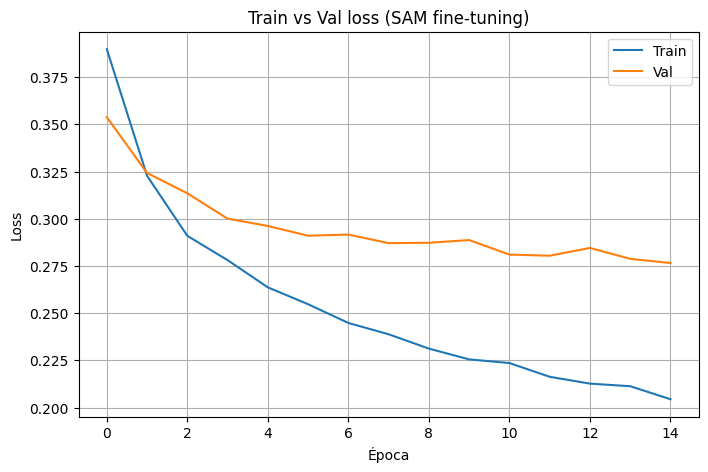

In [29]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses,   label="Val")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Train vs Val loss (SAM fine-tuning)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Carregar checkpoint "best" salvo durante o treino
best_ckpt_path = "/kaggle/working/sam_cod10k_best.pth"

checkpoint = torch.load(best_ckpt_path, map_location=device)
print("Checkpoint carregado da época:", checkpoint["epoch"])

# Recriar o modelo SAM e carregar os pesos
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Congelar encoders e deixar só decoder treinável (igual no treino – só por consistência)
for param in model.vision_encoder.parameters():
    param.requires_grad = False
for param in model.prompt_encoder.parameters():
    param.requires_grad = False
for param in model.mask_decoder.parameters():
    param.requires_grad = True

model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

# (Opcional) recuperar curvas de treino/val só para conferência
train_losses = checkpoint.get("train_losses", [])
val_losses   = checkpoint.get("val_losses", [])

print(f"Train losses armazenadas: {len(train_losses)} | Val losses armazenadas: {len(val_losses)}")


Checkpoint carregado da época: 15
Train losses armazenadas: 15 | Val losses armazenadas: 15


In [36]:
test_loss_total = 0.0
n_test_steps = 0

all_iou  = []
all_dice = []

model.eval()

with torch.no_grad():
    test_bar = tqdm(test_dataloader, desc="Test")
    for batch in test_bar:
        pixel_values = batch["pixel_values"].to(device)  # [B, 3, 1024, 1024]

        for i in range(pixel_values.shape[0]):
            # 1) imagem i
            curr_pixel_values = pixel_values[i].unsqueeze(0)  # [1, 3, 1024, 1024]

            # 2) caixas da imagem i
            curr_boxes = batch["input_boxes"][i].to(device)   # [N_inst, 4]
            curr_boxes = curr_boxes.unsqueeze(0)              # [1, N_inst, 4]

            # 3) máscaras GT da imagem i
            curr_gt_masks = batch["ground_truth_masks"][i].to(device).unsqueeze(1)
            # shape: [N_inst, 1, 256, 256]

            # 4) forward
            outputs = model(
                pixel_values=curr_pixel_values,
                input_boxes=curr_boxes,
                multimask_output=False,
            )
            pred_masks = outputs.pred_masks.squeeze(0)  # [N_inst, 1, 256, 256]

            # 5) loss
            loss = criterion(pred_masks, curr_gt_masks)
            test_loss_total += loss.item()
            n_test_steps += 1

            # 6) métricas binárias (threshold 0.5)
            probs = torch.sigmoid(pred_masks)
            preds_bin = (probs > 0.5).float()  # [N_inst, 1, 256, 256]

            # Flatten por instância
            intersection = (preds_bin * curr_gt_masks).sum(dim=(1, 2, 3))
            union = ((preds_bin + curr_gt_masks) > 0).float().sum(dim=(1, 2, 3))

            iou  = (intersection / (union + 1e-6)).mean().item()
            dice = (2 * intersection / (preds_bin.sum(dim=(1, 2, 3)) +
                                        curr_gt_masks.sum(dim=(1, 2, 3)) + 1e-6)).mean().item()

            all_iou.append(iou)
            all_dice.append(dice)

        avg_test_loss_so_far = test_loss_total / max(1, n_test_steps)
        test_bar.set_postfix({"test_loss": f"{avg_test_loss_so_far:.4f}"})

avg_test_loss = test_loss_total / max(1, n_test_steps)
mean_iou  = float(np.mean(all_iou))  if len(all_iou)  > 0 else float("nan")
mean_dice = float(np.mean(all_dice)) if len(all_dice) > 0 else float("nan")

print("\n==== RESULTADOS NO TESTE ====")
print(f"Test loss médio: {avg_test_loss:.4f}")
print(f"Test IoU médio:  {mean_iou:.4f}")
print(f"Test Dice médio: {mean_dice:.4f}")

Test: 100%|██████████| 19/19 [02:44<00:00,  8.64s/it, test_loss=0.2594]


==== RESULTADOS NO TESTE ====
Test loss médio: 0.2594
Test IoU médio:  0.5112
Test Dice médio: 0.6466


In [18]:
# Carregar modelo original do zero (sem fine-tuning)
model_pretrained = SamModel.from_pretrained("facebook/sam-vit-base")

# Congelar só por segurança (não será treinado)
for param in model_pretrained.parameters():
    param.requires_grad = False

model_pretrained.to(device)
model_pretrained.eval()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [34]:
test_loss_total = 0.0
n_test_steps = 0

all_iou  = []
all_dice = []

model_pretrained.eval()

with torch.no_grad():
    test_bar = tqdm(test_dataloader, desc="Test (pretrained)")
    for batch in test_bar:
        pixel_values = batch["pixel_values"].to(device)

        for i in range(pixel_values.shape[0]):
            curr_pixel_values = pixel_values[i].unsqueeze(0)

            curr_boxes = batch["input_boxes"][i].to(device)
            curr_boxes = curr_boxes.unsqueeze(0)

            curr_gt_masks = batch["ground_truth_masks"][i].to(device).unsqueeze(1)

            outputs = model_pretrained(
                pixel_values=curr_pixel_values,
                input_boxes=curr_boxes,
                multimask_output=False,
            )
            pred_masks = outputs.pred_masks.squeeze(0)

            loss = criterion(pred_masks, curr_gt_masks)
            test_loss_total += loss.item()
            n_test_steps += 1

            # Métricas
            probs = torch.sigmoid(pred_masks)
            preds_bin = (probs > 0.5).float()

            intersection = (preds_bin * curr_gt_masks).sum(dim=(1,2,3))
            union = ((preds_bin + curr_gt_masks) > 0).float().sum(dim=(1,2,3))

            iou = (intersection / (union + 1e-6)).mean().item()
            dice = (2 * intersection /
                    (preds_bin.sum(dim=(1,2,3)) + curr_gt_masks.sum(dim=(1,2,3)) + 1e-6)
                   ).mean().item()

            all_iou.append(iou)
            all_dice.append(dice)

        avg_test_loss_so_far = test_loss_total / max(1, n_test_steps)
        test_bar.set_postfix({"test_loss": f"{avg_test_loss_so_far:.4f}"})

avg_test_loss = test_loss_total / n_test_steps
mean_iou  = float(np.mean(all_iou))
mean_dice = float(np.mean(all_dice))

print("\n==== RESULTADOS (SAM PRÉ-TREINADO) ====")
print(f"Test loss médio: {avg_test_loss:.4f}")
print(f"Test IoU médio:  {mean_iou:.4f}")
print(f"Test Dice médio: {mean_dice:.4f}")


Test (pretrained): 100%|██████████| 19/19 [02:28<00:00,  7.80s/it, test_loss=0.6270]


==== RESULTADOS (SAM PRÉ-TREINADO) ====
Test loss médio: 0.6270
Test IoU médio:  0.1392
Test Dice médio: 0.2082
